In [ ]:
# | default_exp analyses.pnr
%load_ext autoreload
%autoreload 2

# Probability of Nth Recall
The **probability of nth recall** (PNR) analysis examines which studied items, by their serial position, end up as the *n*-th recalled item.

- `fixed_pres_pnr` assumes uniform study lists (no item repetitions). It simply tallies which item was recalled in the *n*-th position.
- `pnr` generalizes to the case where items can repeat during study. It uses the auxiliary function `all_study_positions` to handle these repetitions properly.

The resulting vector from these functions is of length equal to the study list length, showing for each position in the study list, how often (probability) it corresponds to the *n*-th recall event.

In [ ]:
# | export

from typing import Optional, Sequence

import jax.numpy as jnp
from jax import jit, vmap, lax
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes

from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.repetition import all_study_positions
from jaxcmr.helpers import apply_by_subject, find_max_list_length
from jaxcmr.typing import Array, Bool, Float, Integer, RecallDataset


 ## Simple Case: When Study Lists are Uniform

 When all lists are uniform (no repeated items), we can identify the item recalled in the *n*-th position by looking directly at `recalls[:, query_recall_position]` and doing a simple count:

In [ ]:
# | exports


def fixed_pres_pnr(
    recalls: Integer[Array, " trial_count recall_positions"],
    list_length: int,
    query_recall_position: int = 0,
) -> Float[Array, " study_positions"]:
    """Returns probability of nth recall as a function of study position, assuming uniform study lists.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        list_length: the length of the study list.
        query_recall_position: Which recall index (0-based) to analyze (e.g., 0 for first recall).
    """
    # Identify the item recalled at the query_recall_position for each trial.
    # Bin counts for each item number, ignoring 0 (no recall).
    # Divide by the total number of trials to get a probability.
    return jnp.bincount(
        recalls[:, query_recall_position].flatten(), length=list_length + 1
    )[1:] / len(recalls)


And a modification to provide a probability of the *n*-th recall at each study position conditional on the study position being unrecalled by the *n*-th recall.

In [ ]:
# | exports


def available_recalls(
    recalls: Integer[Array, " recall_positions"],
    query_recall_position: int,
    list_length: int,
) -> Bool[Array, " list_length"]:
    """Returns boolean mask of study positions still available for recall at recall position.

    Assumes:
      - query_recall_position is static
      - recalls are 1-indexed, with 0 meaning no recall
    """
    prior = recalls[:query_recall_position]
    init = jnp.ones(list_length + 1, dtype=bool)
    final_mask, _ = lax.scan(lambda m, i: (m.at[i].set(False), None), init, prior)

    return final_mask[1:]


def actual_recalls(
    recalls: Integer[Array, " recall_positions"],
    query_recall_position: int,
    list_length: int,
) -> Bool[Array, " list_length"]:
    """Returns a boolean mask where only the position of the recalled item is True.

    If no item was recalled at the query position, returns all False.
    Assumes 1-indexed items, 0 = no recall.
    """
    item = recalls[query_recall_position]
    return jnp.where(
        item == 0,
        jnp.zeros(list_length, dtype=bool),
        jnp.arange(1, list_length + 1) == item,
    )


def conditional_fixed_pres_pnr(
    recalls: Integer[Array, " trial recall_positions"],
    list_length: int,
    query_recall_position: int,
) -> Float[Array, " list_length"]:
    """Returns conditional PNR as actual / available per study position.

    Each element i gives the probability that position i was recalled at
    query_recall_position, conditioned on it being available.
    """

    # shape (trial, list_length)
    actual = vmap(actual_recalls, in_axes=(0, None, None))(
        recalls, query_recall_position, list_length
    )
    available = vmap(available_recalls, in_axes=(0, None, None))(
        recalls, query_recall_position, list_length
    )

    numerator = actual.sum(axis=0)  # times each pos was the nth recall
    denominator = available.sum(axis=0)  # times each pos was available

    # Avoid divide-by-zero
    return jnp.where(denominator > 0, numerator / denominator, 0.0)

 ## Complex Case: Item Repetitions

 If items can repeat, we need to track all possible study positions for the *n*-th recalled item.

 For each trial and each recalled item, `all_study_positions` returns all positions in the study list at which the recalled item appeared. The final probability is then computed similarly to the uniform case, but using the expanded array that captures repeated study positions.

In [ ]:
# | exports


def pnr(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations: Integer[Array, " trial_count study_positions"],
    list_length: int,
    size: int = 3,
    query_recall_position: int = 0,
) -> Float[Array, " study_positions"]:
    """Returns probability of nth recall as a function of study position, allowing item repetitions.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        list_length: the length of the study list.
        size: maximum number of study positions an item can be presented at.
        query_recall_position: Which recall index (0-based) to analyze (e.g., 0 for first recall).
    """
    # expanded_recalls: (trial_count, recall_positions, size) array
    # where each recalled item is mapped to all its possible study positions.
    expanded_recalls = vmap(
        vmap(all_study_positions, in_axes=(0, None, None)), in_axes=(0, 0, None)
    )(recalls, presentations, size)
    return fixed_pres_pnr(expanded_recalls, list_length, query_recall_position)


In [ ]:
#| exports

def available_recalls_with_repeats(
    recalls: Integer[Array, " recall_positions"],
    presentations: Integer[Array, " list_length"],
    query_recall_position: int,
    list_length: int,
    size: int,
) -> Bool[Array, " list_length"]:
    """Returns a boolean mask of available study positions at recall position.

    A study position is unavailable if its item has been recalled earlier.
    Uses all_study_positions to account for item repetition.
    """
    prior = vmap(all_study_positions, in_axes=(0, None, None))(
        recalls[:query_recall_position], presentations, size
    ).reshape(-1)

    init = jnp.ones(list_length + 1, dtype=bool)
    final_mask, _ = lax.scan(lambda m, p: (m.at[p].set(False), None), init, prior)

    return final_mask[1:]


def actual_recalls_with_repeats(
    recalls: Integer[Array, " recall_positions"],
    presentations: Integer[Array, " list_length"],
    query_recall_position: int,
    list_length: int,
    size: int,
) -> Bool[Array, " list_length"]:
    """Returns a boolean mask where study positions for the recalled item are True.

    Uses all_study_positions to handle item repetitions in the study list.
    """
    item = recalls[query_recall_position]
    current = all_study_positions(item, presentations, size)  # shape: (size,)

    init = jnp.zeros(list_length + 1, dtype=bool)
    final_mask, _ = lax.scan(lambda m, p: (m.at[p].set(True), None), init, current)
    return final_mask[1:]


def conditional_pnr_with_repeats(
    recalls: Integer[Array, " trial recall_positions"],
    presentations: Integer[Array, " trial list_length"],
    list_length: int,
    size: int,
    query_recall_position: int,
) -> Float[Array, " list_length"]:
    """Returns conditional PNR under item repetitions.

    Computes actual / available for each study position across trials.
    """
    actual = vmap(actual_recalls_with_repeats, in_axes=(0, 0, None, None, None))(
        recalls, presentations, query_recall_position, list_length, size
    )
    available = vmap(available_recalls_with_repeats, in_axes=(0, 0, None, None, None))(
        recalls, presentations, query_recall_position, list_length, size
    )

    numerator = actual.sum(axis=0)
    denominator = available.sum(axis=0)

    return jnp.where(denominator > 0, numerator / denominator, 0.0)

In [ ]:
recalls = jnp.array([
    [2, 1, 3],
    [4, 3, 2],
])
presentations = jnp.array([
    [1, 2, 3, 1, 3],
    [2, 3, 4, 2, 5],
])
query_recall_position = 2
list_length = 5
size = 2

expected = jnp.array([0.0, 1.0, 1.0, 0.0, 0.5])
out = conditional_pnr_with_repeats(recalls, presentations, list_length, size, query_recall_position)
assert jnp.allclose(out, expected), out

In [ ]:
recalls = jnp.array([4, 2, 1])
presentations = jnp.array([1, 2, 3, 4, 5])  # Each item appears once
query_recall_position = 0  # item 4 is recalled
list_length = 5
size = 2  # doesn't matter here — only one match

# item 4 appears only at position 4 → index 3 (0-based)
expected = jnp.array([False, False, False, True, False])
out = actual_recalls_with_repeats(
    recalls, presentations, query_recall_position, list_length, size
)
assert jnp.all(out == expected)

In [ ]:
recalls = jnp.array([2, 1, 3])
presentations = jnp.array([1, 2, 3, 1, 3])
query_recall_position = 2
list_length = 5
size = 2

expected = jnp.array([False, False, True, False, True])
out = actual_recalls_with_repeats(
    recalls, presentations, query_recall_position, list_length, size
)
assert jnp.all(out == expected)

In [ ]:
recalls = jnp.array([3, 0, 0])
presentations = jnp.array([1, 2, 3, 1, 3])
query_recall_position = 1
list_length = 5
size = 2

expected = jnp.array([True, True, False, True, False])
out = available_recalls_with_repeats(
    recalls, presentations, query_recall_position, list_length, size
)
assert jnp.all(out == expected)

 ## Plotting the Probability of Nth Recall

 The `plot_pnr` function produces a simple line plot for the PNR across multiple datasets and/or trial masks.

 By default, it plots the probability of first recall (i.e., `query_recall_position=0`).

In [ ]:
# | exports


def plot_pnr(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    query_recall_position: int = 0,
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted probability of nth recall for given datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        query_recall_position: Which recall index (0-based) to plot (e.g., 0 for first recall).
        distances: Unused, included for compatibility with other plotting functions.
        color_cycle: List of colors for plotting each dataset.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    # Convert single dict or single mask to list
    if isinstance(datasets, dict):
        datasets = [datasets]
    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    # Determine x-axis length
    max_list_length = find_max_list_length(datasets, trial_masks)

    # For each dataset, apply the pnr function by subject, gather results, and plot
    for data_index, data in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data,
                trial_masks[data_index],
                jit(conditional_pnr_with_repeats, static_argnames=("size", "list_length", "query_recall_position")),
                size,
                query_recall_position,
            )
        )

        color = color_cycle.pop(0)
        plot_data(
            axis,
            jnp.arange(max_list_length, dtype=int) + 1,
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Study Position", "Probability of Nth Recall", contrast_name)
    return axis

 ## Tests

 ### Equivalent Outputs for Uniform Study Lists

 When the study lists are identical for every trial (and contain no repeated items), `fixed_pres_pnr` and `pnr` should produce the same output.

In [ ]:
presentation_uniform = jnp.array(
    [[1, 2, 3], [1, 2, 3]]
)  # same list repeated across two trials
recalls_uniform = jnp.array([[1, 2, 3], [2, 3, 1]])  # each row is a trial
list_length_test = presentation_uniform.shape[1]

# Probability of first recall for both trials
pnr_uniform = pnr(
    recalls_uniform,
    presentation_uniform,
    list_length_test,
    size=1,
    query_recall_position=0,
)
fixed_uniform = fixed_pres_pnr(
    recalls_uniform, list_length_test, query_recall_position=0
)

assert jnp.allclose(pnr_uniform, fixed_uniform), "PNR mismatch with uniform study lists"
pnr_uniform


Array([0.5, 0.5, 0. ], dtype=float32)

 ### Insensitivity to Zero Padding
Adding zeros to the presentations or recalls (beyond the intended list length) should not affect the probability of nth recall.

In [ ]:
# Extend the presentations and recalls with zero padding
presentation_padded = jnp.array([[1, 2, 3, 0, 0], [1, 2, 3, 0, 0]])
recalls_padded = jnp.array([[2, 3, 1, 0, 0], [1, 2, 3, 0, 0]])

pnr_padded = pnr(
    recalls_padded, presentation_padded, 3, size=2, query_recall_position=0
)
assert jnp.allclose(pnr_padded, pnr_uniform), "PNR changed due to zero padding"
pnr_padded


Array([0.5, 0.5, 0. ], dtype=float32)

 ### Sensitivity to Repetitions
 The `pnr` function will attribute the nth recall to *all* study positions for an item that appears multiple times. For instance, if item 4 appears in positions 2 and 5, and is the nth recall, that nth recall will be counted once for position 2 **and** once for position 5.

In [ ]:
presentations_repeated = jnp.array([[1, 2, 3, 2, 4]])
recalls_repeated = jnp.array([[2, 1, 3, 0]])
list_length_test_reps = 5

# Probability of first recall
# Item "4" appears at positions 2 and 4. It is recalled first. So positions 2 and 4 should share that credit.
expected_pnr = jnp.array(
    [0.0, 1.0, 0.0, 1.0, 0.0]
)  # "4" => positions 2 & 4; 1-based indexing in the array

out_pnr = pnr(
    recalls_repeated,
    presentations_repeated,
    list_length_test_reps,
    query_recall_position=0,
)
assert jnp.allclose(out_pnr, expected_pnr), "PNR mismatch for repeated items"
out_pnr


Array([0., 1., 0., 1., 0.], dtype=float32)

### Varying `query_recall_position`

We can test whether changing `query_recall_position` (e.g., first vs. second vs. third recall) yields sensible results.

In [ ]:
# We'll reuse the uniform lists from above
# For the second recall (index=1), let's see which item is recalled in each trial:
#   Trial 1: [1, 2, 3] => second recall is item 2
#   Trial 2: [2, 3, 1] => second recall is item 3
# So positions of items 2,3 in the uniform list are (2, 3) respectively.
# Probability for each position => item 2's position is 2, item 3's position is 3

pnr_second_recall = pnr(
    recalls_uniform,
    presentation_uniform,
    list_length_test,
    size=1,
    query_recall_position=1,
)
expected_second_recall = jnp.array(
    [0.0, 0.5, 0.5]
)  # half the time it's position 2, half it's position 3

assert jnp.allclose(pnr_second_recall, expected_second_recall), "Second recall mismatch"
pnr_second_recall


Array([0. , 0.5, 0.5], dtype=float32)

### Conditional Probability

In [ ]:
# | code-summary: test that conditional_pnr works

recalls = jnp.array(
    [
        [1, 2, 3, 0, 0],
        [3, 2, 1, 0, 0],
        [1, 3, 2, 0, 0],
    ]
)
query_recall_position = 2
list_length = 5

expected = jnp.array([1.0, 1.0, 1.0, 0.0, 0.0])
fn = jit(
    conditional_fixed_pres_pnr, static_argnames=("list_length", "query_recall_position")
)
out = fn(recalls, list_length, query_recall_position)
assert jnp.allclose(out, expected)

 ## Examples

In [ ]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

 Uniform study lists case. This yields some warnings because there's a study position for which the first recall probability is zero, but that's okay:

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Array([0.21666667, 0.06190477, 0.03333334, 0.04047619, 0.00952381,
       0.01666667, 0.        , 0.02142857, 0.01190476, 0.01190476,
       0.01428572, 0.01428572, 0.0047619 , 0.00714286, 0.00952381,
       0.00238095, 0.00952381, 0.01190476, 0.0047619 , 0.00952381,
       0.0047619 , 0.01428572, 0.00952381, 0.00714286, 0.01190476,
       0.01190476, 0.00952381, 0.02142857, 0.01428572, 0.01190476,
       0.02619048, 0.01190476, 0.01428572, 0.01904762, 0.01190476,
       0.03571429, 0.05238095, 0.06190477, 0.06428572, 0.07380953],      dtype=float32)

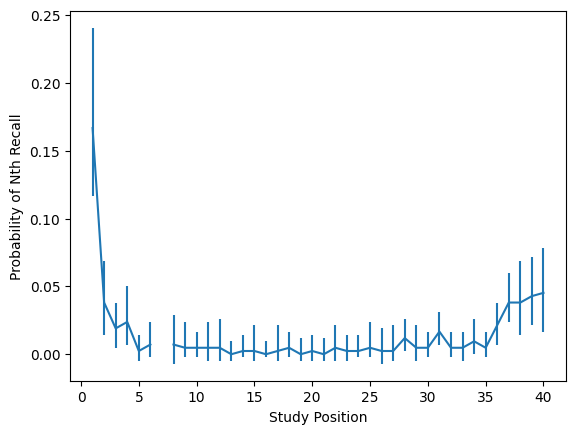

In [ ]:
# parameters
run_tag = "PFR"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_pnr(data, generate_trial_mask(data, data_query))
jit(pnr, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)


 Study lists where every item is repeated once immediately after its first presentation. In this example, each pair of successive study positions in the plot should produce the same recall rate.

Array([0.34761906, 0.34761906, 0.06904762, 0.06904762, 0.0452381 ,
       0.0452381 , 0.03333334, 0.03333334, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01428572, 0.01428572, 0.01666667,
       0.01666667, 0.01190476, 0.01190476, 0.02380952, 0.02380952,
       0.01666667, 0.01666667, 0.01904762, 0.01904762, 0.02142857,
       0.02142857, 0.02619048, 0.02619048, 0.03333334, 0.03333334,
       0.03095238, 0.03095238, 0.04047619, 0.04047619, 0.04285714,
       0.04285714, 0.06904762, 0.06904762, 0.1       , 0.1       ],      dtype=float32)

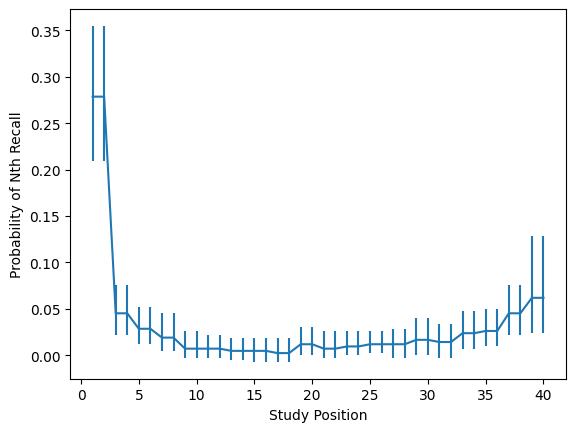

In [ ]:
# parameters
run_tag = "PFR"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 2"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_pnr(data, generate_trial_mask(data, data_query))
jit(pnr, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)
